# Nb-20180308-2137-BigGainPredict

This is continuation of previous BigGainPredict after implementing Bollinger Bands...

So,  get list of mega, large, and mid-cap companies on NYSE for looking for 1% price gain prediction using machine learning.

- https://www.nasdaq.com/screening/companies-by-industry.aspx?exchange=NYSE&marketcap=Mega-cap
- https://www.nasdaq.com/screening/companies-by-industry.aspx?exchange=NYSE&marketcap=Large-cap
- https://www.nasdaq.com/screening/companies-by-industry.aspx?exchange=NYSE&marketcap=Mid-cap

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.colors as colors
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [3]:
import finance as fat

In [4]:
# Change the plot size.
plt.rcParams['figure.figsize'] = [18.0, 10.0]

### Load Company Data

In [5]:
c = pd.read_csv('data/NYSE-Companies-Mega-Large-Mid-Cap.csv')

In [6]:
c.head()

,Symbol,Name,LastSale,MarketCap,ADR TSO,IPOyear,Sector,Industry,Summary Quote,Unnamed: 9
0,BABA,Alibaba Group Holding Limited,187.18,4.802729e+11,NaN,2014.0,Miscellaneous,Business Services,https://www.nasdaq.com/symbol/baba,NaN
1,T,AT&T Inc.,37.11,2.279123e+11,NaN,NaN,Public Utilities,Telecommunications Equipment,https://www.nasdaq.com/symbol/t,NaN
2,BAC,Bank of America Corporation,32.20,3.298468e+11,NaN,NaN,Finance,Major Banks,https://www.nasdaq.com/symbol/bac,NaN
3,BA,Boeing Company (The),348.73,2.052242e+11,NaN,NaN,Capital Goods,Aerospace,https://www.nasdaq.com/symbol/ba,NaN
4,CVX,Chevron Corporation,113.35,2.165272e+11,NaN,NaN,Energy,Integrated oil Companies,https://www.nasdaq.com/symbol/cvx,NaN


In [7]:
c = c.sort_values('MarketCap',ascending=False)

In [8]:
c.head()

,Symbol,Name,LastSale,MarketCap,ADR TSO,IPOyear,Sector,Industry,Summary Quote,Unnamed: 9
0,BABA,Alibaba Group Holding Limited,187.18,4.802729e+11,NaN,2014.0,Miscellaneous,Business Services,https://www.nasdaq.com/symbol/baba,NaN
7,JPM,J P Morgan Chase & Co,114.74,3.937829e+11,NaN,NaN,Finance,Major Banks,https://www.nasdaq.com/symbol/jpm,NaN
8,JNJ,Johnson & Johnson,132.06,3.543040e+11,NaN,NaN,Health Care,Major Pharmaceuticals,https://www.nasdaq.com/symbol/jnj,NaN
2,BAC,Bank of America Corporation,32.20,3.298468e+11,NaN,NaN,Finance,Major Banks,https://www.nasdaq.com/symbol/bac,NaN
5,XOM,Exxon Mobil Corporation,74.12,3.140807e+11,NaN,NaN,Energy,Integrated oil Companies,https://www.nasdaq.com/symbol/xom,NaN


### Create features

These are some ideas from a paper: _A Feature Fusion Based Forecasting Model for Financial Time Series_ by
Zhiqiang Guo , Huaiqing Wang, Quan Liu, Jie Yang
- http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0101113

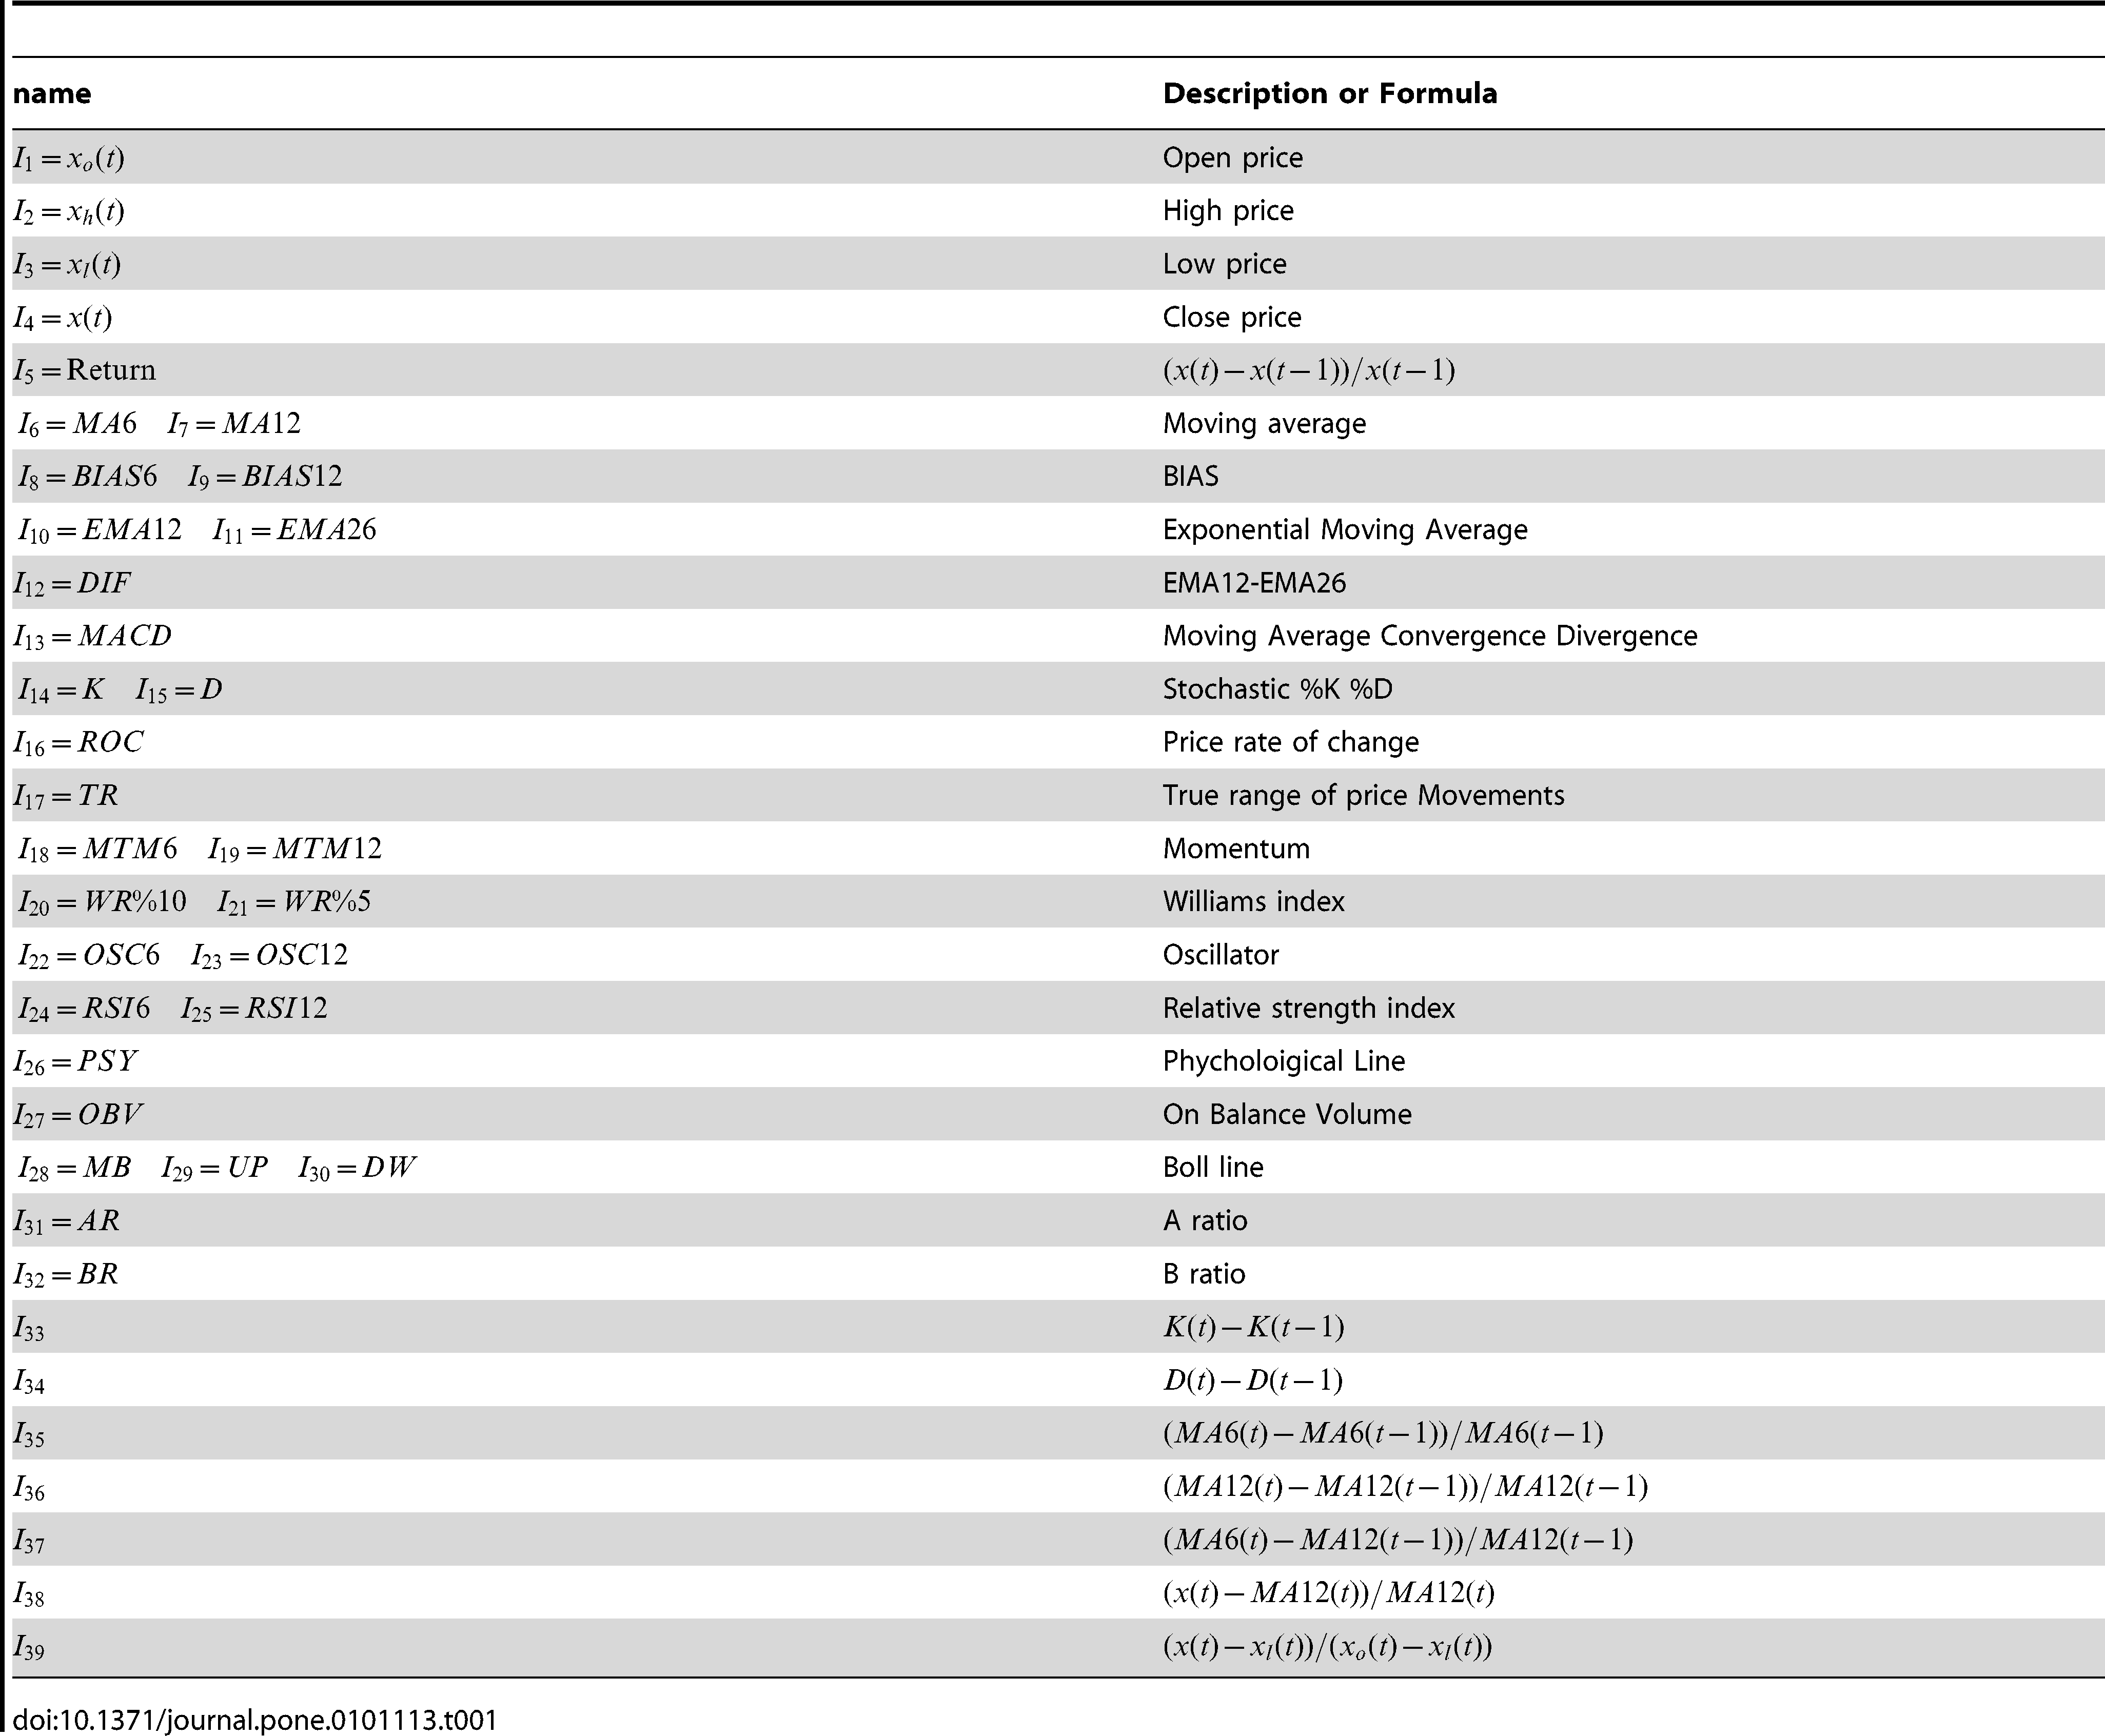

We'll start of with a sub-set of these:

### Create scalable features

First, create features that can be linearly scaled (within a row).

**Hypothesis**: having all price data scaled between 0.0-1.0 on a per row basis will improve ease of training and accuracy of predicitions.

In [9]:
ticker = c.iloc[1]['Symbol']

In [57]:
data = fat.get_price_data(ticker)
ohlcv = data

Loaded data for JPM: 1980-03-17 to 2018-03-07.


In [58]:
# Just use 'Adj Close'
data = pd.DataFrame(data, columns=['Adj Close'])
data.head()

,Adj Close
Date,
1980-03-17,1.284682
1980-03-18,1.294128
1980-03-19,1.313020
1980-03-20,1.303574
1980-03-21,1.331913


In [59]:
# Gain
data['Gain'] = data['Adj Close'].diff()
data.head()

,Adj Close,Gain
Date,,
1980-03-17,1.284682,NaN
1980-03-18,1.294128,0.009446
1980-03-19,1.313020,0.018892
1980-03-20,1.303574,-0.009446
1980-03-21,1.331913,0.028339


In [60]:
# SMA: 6, 12, 20, 200
data = fat.add_sma_columns(data, 'Adj Close', [6,12])
data.tail()

,Adj Close,Gain,Adj Close SMA6,Adj Close SMA12
Date,,,,
2018-03-01,113.430000,-2.070000,116.225000,115.408333
2018-03-02,113.320000,-0.110000,115.948333,115.482500
2018-03-05,115.059998,1.739998,115.573333,115.485000
2018-03-06,115.160004,0.100006,114.971667,115.455833
2018-03-07,114.730003,-0.430001,114.533334,115.460000


In [61]:
data = fat.add_ema_columns(data, 'Adj Close', [12,26])
data.tail()

,Adj Close,Gain,Adj Close SMA6,Adj Close SMA12,Adj Close EMA12,Adj Close EMA26
Date,,,,,,
2018-03-01,113.430000,-2.070000,116.225000,115.408333,115.164644,114.012405
2018-03-02,113.320000,-0.110000,115.948333,115.482500,114.880853,113.961115
2018-03-05,115.059998,1.739998,115.573333,115.485000,114.908414,114.042514
2018-03-06,115.160004,0.100006,114.971667,115.455833,114.947120,114.125291
2018-03-07,114.730003,-0.430001,114.533334,115.460000,114.913717,114.170085


In [62]:
data = fat.add_bollinger_bands(data, 'Adj Close')
data.tail()

,Adj Close,Gain,Adj Close SMA6,Adj Close SMA12,Adj Close EMA12,Adj Close EMA26,Adj Close SMA20,Adj Close BBandHi20,Adj Close BBandLo20
Date,,,,,,,,,
2018-03-01,113.430000,-2.070000,116.225000,115.408333,115.164644,114.012405,113.9745,119.689804,108.259197
2018-03-02,113.320000,-0.110000,115.948333,115.482500,114.880853,113.961115,113.7970,119.351924,108.242076
2018-03-05,115.059998,1.739998,115.573333,115.485000,114.908414,114.042514,113.8360,119.416097,108.255903
2018-03-06,115.160004,0.100006,114.971667,115.455833,114.947120,114.125291,114.1540,119.227612,109.080389
2018-03-07,114.730003,-0.430001,114.533334,115.460000,114.913717,114.170085,114.2850,119.270937,109.299064


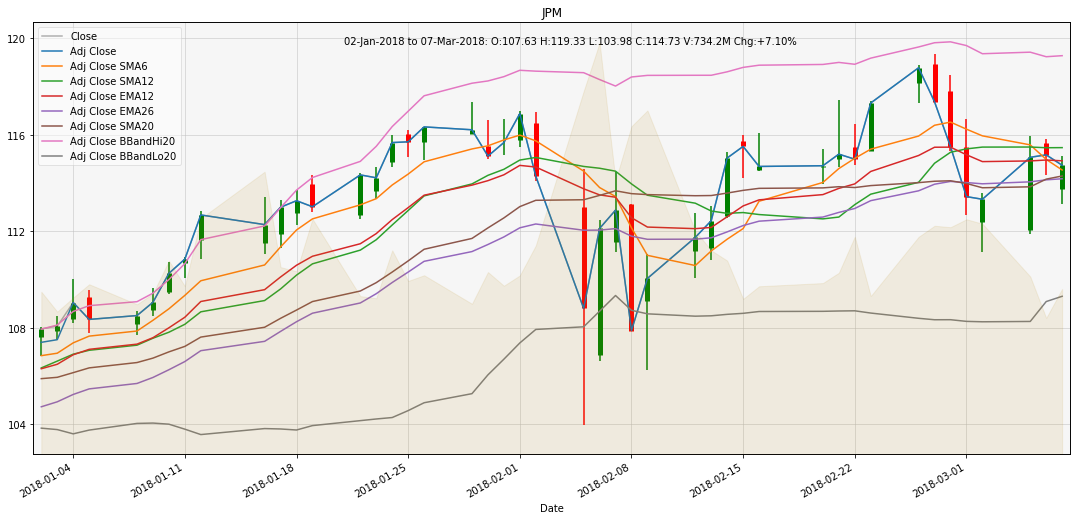

In [63]:
overlay = data.copy()
del overlay['Gain']
fat.plot_daily_ticker(ohlcv['2018'], title=ticker, overlay=overlay)

In [76]:
data['Return'] = data['Gain']/data['Adj Close'].shift(1)
data.tail()

,Adj Close,Gain,Adj Close SMA6,Adj Close SMA12,Adj Close EMA12,Adj Close EMA26,Adj Close SMA20,Adj Close BBandHi20,Adj Close BBandLo20,Return
Date,,,,,,,,,,
2018-03-01,113.430000,-2.070000,116.225000,115.408333,115.164644,114.012405,113.9745,119.689804,108.259197,-0.017922
2018-03-02,113.320000,-0.110000,115.948333,115.482500,114.880853,113.961115,113.7970,119.351924,108.242076,-0.000970
2018-03-05,115.059998,1.739998,115.573333,115.485000,114.908414,114.042514,113.8360,119.416097,108.255903,0.015355
2018-03-06,115.160004,0.100006,114.971667,115.455833,114.947120,114.125291,114.1540,119.227612,109.080389,0.000869
2018-03-07,114.730003,-0.430001,114.533334,115.460000,114.913717,114.170085,114.2850,119.270937,109.299064,-0.003734


In [98]:
data['IsBigGain'] = data['Return'] > 0.01
data['IsNextDayBigGain'] = data['IsBigGain'].shift(-1)
data.tail()

,Adj Close,Gain,Adj Close SMA6,Adj Close SMA12,Adj Close EMA12,Adj Close EMA26,Adj Close SMA20,Adj Close BBandHi20,Adj Close BBandLo20,Return,IsBigGain,IsNextDayBigGain
Date,,,,,,,,,,,,
2018-03-01,113.430000,-2.070000,116.225000,115.408333,115.164644,114.012405,113.9745,119.689804,108.259197,-0.017922,False,False
2018-03-02,113.320000,-0.110000,115.948333,115.482500,114.880853,113.961115,113.7970,119.351924,108.242076,-0.000970,False,True
2018-03-05,115.059998,1.739998,115.573333,115.485000,114.908414,114.042514,113.8360,119.416097,108.255903,0.015355,True,False
2018-03-06,115.160004,0.100006,114.971667,115.455833,114.947120,114.125291,114.1540,119.227612,109.080389,0.000869,False,False
2018-03-07,114.730003,-0.430001,114.533334,115.460000,114.913717,114.170085,114.2850,119.270937,109.299064,-0.003734,False,NaN


Let's scale and make sure things look similar...

In [99]:
scale_factor = data.max().max()*2
scale_factor

239.68901719776977

In [100]:
scaled_data = data / scale_factor
scaled_overlay = overlay / scale_factor 
scaled_ohlcv = ohlcv / scale_factor

In [101]:
scaled_data.tail()

,Adj Close,Gain,Adj Close SMA6,Adj Close SMA12,Adj Close EMA12,Adj Close EMA26,Adj Close SMA20,Adj Close BBandHi20,Adj Close BBandLo20,Return,IsBigGain,IsNextDayBigGain
Date,,,,,,,,,,,,
2018-03-01,0.473238,-0.008636,0.484899,0.481492,0.480475,0.475668,0.475510,0.499355,0.451665,-0.000075,0,0
2018-03-02,0.472779,-0.000459,0.483745,0.481801,0.479291,0.475454,0.474769,0.497945,0.451594,-0.000004,0,0.00417207
2018-03-05,0.480039,0.007259,0.482180,0.481812,0.479406,0.475794,0.474932,0.498213,0.451651,0.000064,0.00417207,0
2018-03-06,0.480456,0.000417,0.479670,0.481690,0.479568,0.476139,0.476259,0.497426,0.455091,0.000004,0,0
2018-03-07,0.478662,-0.001794,0.477841,0.481708,0.479428,0.476326,0.476805,0.497607,0.456004,-0.000016,0,NaN


In [102]:
scaled_overlay.tail()

,Adj Close,Adj Close SMA6,Adj Close SMA12,Adj Close EMA12,Adj Close EMA26,Adj Close SMA20,Adj Close BBandHi20,Adj Close BBandLo20
Date,,,,,,,,
2018-03-01,0.473238,0.484899,0.481492,0.480475,0.475668,0.475510,0.499355,0.451665
2018-03-02,0.472779,0.483745,0.481801,0.479291,0.475454,0.474769,0.497945,0.451594
2018-03-05,0.480039,0.482180,0.481812,0.479406,0.475794,0.474932,0.498213,0.451651
2018-03-06,0.480456,0.479670,0.481690,0.479568,0.476139,0.476259,0.497426,0.455091
2018-03-07,0.478662,0.477841,0.481708,0.479428,0.476326,0.476805,0.497607,0.456004


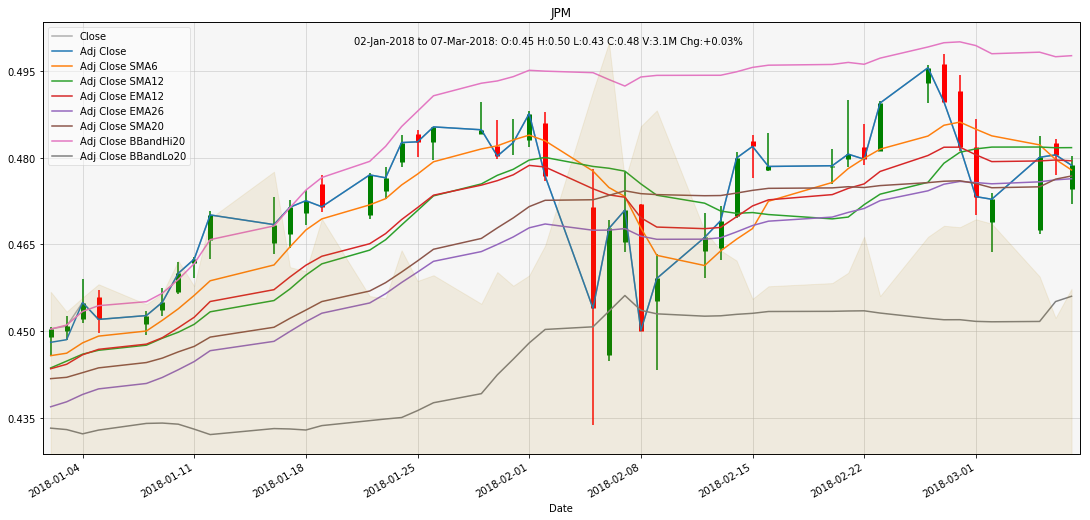

In [103]:
fat.plot_daily_ticker(scaled_ohlcv['2018'], title=ticker, overlay=scaled_overlay)

Try scaling rows...

In [118]:
scaled_rows = data.div(data.max(axis=1)*2, axis=0)
del scaled_rows['Gain']
del scaled_rows['Return']
del scaled_rows['IsBigGain']
scaled_rows['IsNextDayBigGain'] = ((scaled_rows['IsNextDayBigGain'] > 0) * .075) + .45
scaled_rows.tail()

,Adj Close,Adj Close SMA6,Adj Close SMA12,Adj Close EMA12,Adj Close EMA26,Adj Close SMA20,Adj Close BBandHi20,Adj Close BBandLo20,IsNextDayBigGain
Date,,,,,,,,,
2018-03-01,0.47385,0.485526,0.482114,0.481096,0.476283,0.476125,0.5,0.452249,0.450
2018-03-02,0.474731,0.485741,0.48379,0.481269,0.477416,0.476729,0.5,0.453458,0.525
2018-03-05,0.481761,0.48391,0.48354,0.481126,0.477501,0.476636,0.5,0.453272,0.450
2018-03-06,0.482942,0.482152,0.484182,0.482049,0.478603,0.478723,0.5,0.457446,0.450
2018-03-07,0.480964,0.480139,0.484024,0.481734,0.478617,0.479098,0.5,0.458197,0.450


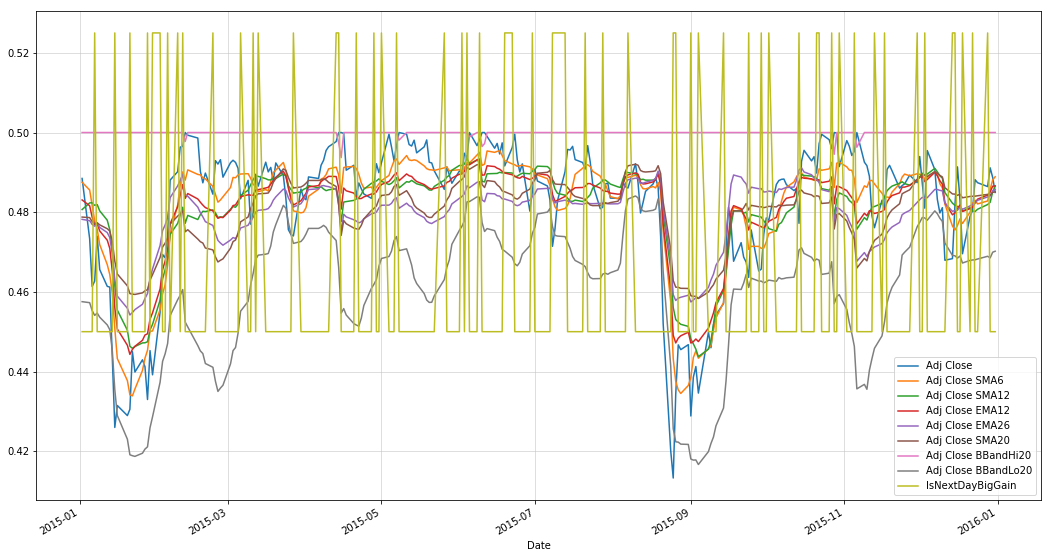

In [123]:
scaled_rows['2015'].plot()